In [5]:
# from utils import Config
from config import Config
import torch.nn as nn   
from ptwt import wavedec3
import torch
class DWT3D(nn.Module):
    """
    3D离散小波变换模块
    使用PyTorch Wavelet Toolbox (ptwt) 实现3D小波变换，支持GPU加速
    对视频数据进行时空域的小波分解，提取多尺度频率信息
    """
    def __init__(self, wavelet=Config.WAVELET_PARAMS['wavelet'], levels=Config.WAVELET_PARAMS['levels']):
        super(DWT3D, self).__init__()
        self.wavelet = wavelet
        self.levels = levels

    def forward(self, video):
        """
        对输入视频进行3D小波变换
        
        参数:
            video (torch.Tensor): 输入视频张量，形状为 [batch, channels, frames, height, width]
            
        返回:
            dict: 多级小波系数字典
                格式: {
                    'level_0': {
                        'channel_0': {
                            'LLL': tensor,  # 近似系数 [batch, 1, frames//2, height//2, width//2]
                            'LLH': tensor,  # 水平细节系数
                            'LHL': tensor,  # 垂直细节系数
                            'LHH': tensor,  # 对角细节系数
                            'HLL': tensor,  # 时间细节系数
                            'HLH': tensor,  # 水平-时间细节系数
                            'HHL': tensor,  # 垂直-时间细节系数
                            'HHH': tensor   # 对角-时间细节系数
                        }
                    }
                }
        """
        batch_size, channels, frames, height, width = video.shape
        all_coeffs = {}
        
        # 确保输入视频需要梯度
        if not video.requires_grad:
            video = video.requires_grad_(True)
        
        try:
            # 使用ptwt进行3D小波变换，直接处理整个批次 (N, C, D, H, W)
            coeffs = wavedec3(video, wavelet=self.wavelet, level=self.levels)
            
            # 处理每个分解级别
            for level in range(self.levels):
                level_key = f'level_{level}'
                if level_key not in all_coeffs:
                    all_coeffs[level_key] = {}
                
                # 根据ptwt返回的格式处理系数 (tuple类型)
                if isinstance(coeffs, tuple) and len(coeffs) > level + 1:
                    coeff_level = coeffs[level + 1]  # 第0个元素是低频分量(LLL)
                    
                    if isinstance(coeff_level, dict):
                        # 处理不同方向的系数，根据字典键含义
                        coeff_dict = coeff_level
                        
                        # 处理每个通道
                        for c in range(channels):
                            channel_key = f'channel_{c}'
                            if channel_key not in all_coeffs[level_key]:
                                all_coeffs[level_key][channel_key] = {}
                            
                            # 获取低频分量 (LLL) - 在coeffs[0]中
                            lll = coeffs[0][:, c:c+1] if level == 0 and coeffs[0].size(1) > c else torch.zeros(batch_size, 1, max(1, frames//2), max(1, height//2), max(1, width//2), device=video.device, requires_grad=True)
                            
                            # 确保所有系数张量都具有正确的梯度设置
                            lll = lll.requires_grad_(True) if video.requires_grad and not lll.requires_grad else lll
                            
                            all_coeffs[level_key][channel_key] = {
                                'LLL': lll,  # 近似系数
                                'LLH': coeff_dict.get('aad', torch.zeros_like(lll))[:, c:c+1] if coeff_dict.get('aad') is not None and coeff_dict['aad'].size(1) > c else torch.zeros_like(lll),
                                'LHL': coeff_dict.get('ada', torch.zeros_like(lll))[:, c:c+1] if coeff_dict.get('ada') is not None and coeff_dict['ada'].size(1) > c else torch.zeros_like(lll),
                                'LHH': coeff_dict.get('add', torch.zeros_like(lll))[:, c:c+1] if coeff_dict.get('add') is not None and coeff_dict['add'].size(1) > c else torch.zeros_like(lll),
                                'HLL': coeff_dict.get('daa', torch.zeros_like(lll))[:, c:c+1] if coeff_dict.get('daa') is not None and coeff_dict['daa'].size(1) > c else torch.zeros_like(lll),
                                'HLH': coeff_dict.get('dad', torch.zeros_like(lll))[:, c:c+1] if coeff_dict.get('dad') is not None and coeff_dict['dad'].size(1) > c else torch.zeros_like(lll),
                                'HHL': coeff_dict.get('dda', torch.zeros_like(lll))[:, c:c+1] if coeff_dict.get('dda') is not None and coeff_dict['dda'].size(1) > c else torch.zeros_like(lll),
                                'HHH': coeff_dict.get('ddd', torch.zeros_like(lll))[:, c:c+1] if coeff_dict.get('ddd') is not None and coeff_dict['ddd'].size(1) > c else torch.zeros_like(lll)
                            }
                            
                            # 确保所有系数都需要梯度
                            for key in all_coeffs[level_key][channel_key]:
                                coeff = all_coeffs[level_key][channel_key][key]
                                # 修改开始：确保所有系数张量都具有正确的梯度设置
                                if video.requires_grad and not coeff.requires_grad:
                                    all_coeffs[level_key][channel_key][key] = coeff.requires_grad_(True)
                                elif not video.requires_grad and coeff.requires_grad:
                                    all_coeffs[level_key][channel_key][key] = coeff.detach()
                                # 修改结束
                    else:
                        # 如果不是字典格式，为每个通道创建默认系数
                        dummy_shape = coeff_level.shape[1:] if isinstance(coeff_level, torch.Tensor) and coeff_level.dim() > 4 else (batch_size, 1, max(1, frames//2), max(1, height//2), max(1, width//2))
                        for c in range(channels):
                            channel_key = f'channel_{c}'
                            # 修改开始：确保默认系数张量具有正确的梯度设置
                            dummy_tensor = torch.zeros(dummy_shape, device=video.device, requires_grad=video.requires_grad) if len(dummy_shape) == 5 else torch.zeros(dummy_shape[0], 1, dummy_shape[1], dummy_shape[2], dummy_shape[3], device=video.device, requires_grad=video.requires_grad)
                            # 修改结束
                            all_coeffs[level_key][channel_key] = {
                                'LLL': dummy_tensor,
                                'LLH': dummy_tensor,
                                'LHL': dummy_tensor,
                                'LHH': dummy_tensor,
                                'HLL': dummy_tensor,
                                'HLH': dummy_tensor,
                                'HHL': dummy_tensor,
                                'HHH': dummy_tensor
                            }
                else:
                    # 如果没有足够的系数级别，为每个通道创建默认系数
                    dummy_shape = (batch_size, 1, max(1, frames//2), max(1, height//2), max(1, width//2))
                    # 修改开始：确保默认系数张量具有正确的梯度设置
                    dummy_tensor = torch.zeros(dummy_shape, device=video.device, requires_grad=video.requires_grad)
                    # 修改结束
                    for c in range(channels):
                        channel_key = f'channel_{c}'
                        all_coeffs[level_key][channel_key] = {
                            'LLL': dummy_tensor,
                            'LLH': dummy_tensor,
                            'LHL': dummy_tensor,
                            'LHH': dummy_tensor,
                            'HLL': dummy_tensor,
                            'HLH': dummy_tensor,
                            'HHL': dummy_tensor,
                            'HHH': dummy_tensor
                        }
                        
        except Exception as e:
            print(f"3D小波变换失败: {e}")
            # 创建默认系数
            dummy_shape = (batch_size, 1, max(1, frames//2), max(1, height//2), max(1, width//2))
            # 修改开始：确保默认系数张量具有正确的梯度设置
            dummy_tensor = torch.zeros(dummy_shape, device=video.device, requires_grad=video.requires_grad)
            # 修改结束
            for level in range(self.levels):
                level_key = f'level_{level}'
                if level_key not in all_coeffs:
                    all_coeffs[level_key] = {}
                for c in range(channels):
                    channel_key = f'channel_{c}'
                    all_coeffs[level_key][channel_key] = {
                        'LLL': dummy_tensor,
                        'LLH': dummy_tensor,
                        'LHL': dummy_tensor,
                        'LHH': dummy_tensor,
                        'HLL': dummy_tensor,
                        'HLH': dummy_tensor,
                        'HHL': dummy_tensor,
                        'HHH': dummy_tensor
                    }
        
        return all_coeffs

In [6]:
from torchvision import transforms
from datasets import create_train_test_datasets
train_root_dir = Config.TRAIN_ROOT_DIR  # 修改为实际训练数据路径
test_root_dir = Config.TEST_ROOT_DIR    # 修改为实际测试数据路径
labels_dir = Config.LABELS_DIR      # 修改为实际标签文件路径
# 定义图像变换
transform = transforms.Compose([
        transforms.Resize(Config.IMAGE_SIZE),
        transforms.ToTensor(),
    ])
    
try:
    # 创建数据集
    train_dataset, test_dataset = create_train_test_datasets(
        train_root_dir=train_root_dir,
        test_root_dir=test_root_dir,
        labels_dir=labels_dir,
        train_transform=transform,
        test_transform=transform,
        max_frames=Config.MAX_FRAMES,
        file_type=Config.FILE_TYPE,
        segment_length=Config.DATASET_PARAMS['segment_length'],
        overlap_ratio=Config.DATASET_PARAMS['overlap_ratio']
    )
    
    print(f"训练集大小: {len(train_dataset)}")
    print(f"测试集大小: {len(test_dataset)}")
    
    if len(train_dataset) > 0:
        print("\n测试加载第一个训练样本:")
        video, labels = train_dataset[0]
        print(f"  视频张量形状: {video.shape}")
        print(f"  标签张量形状: {labels.shape}")
except Exception as e:
    print(f"测试过程中出错: {e}")
    import traceback
    traceback.print_exc()

训练标签文件: E:/dataset/UCSD/UCSDped2/label\train.csv
测试标签文件: E:/dataset/UCSD/UCSDped2/label\test.csv
创建训练数据集...
创建测试数据集...
训练集大小: 350
测试集大小: 300

测试加载第一个训练样本:
  视频张量形状: torch.Size([1, 8, 128, 128])
  标签张量形状: torch.Size([8])


In [11]:
videos = video.unsqueeze(0)
videos.shape

torch.Size([1, 1, 8, 128, 128])

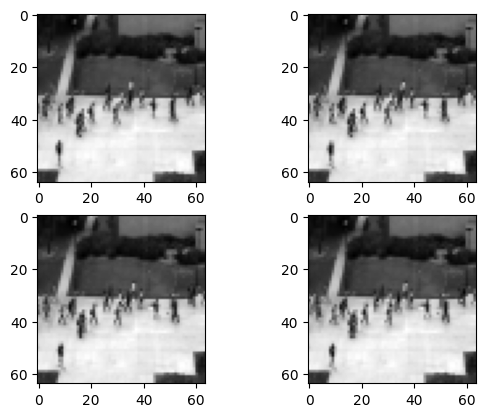

In [26]:
import matplotlib.pyplot as plt
import numpy as np
d3 = DWT3D(levels=1)

res = d3(videos)

ll= res['level_0']['channel_0']['LLL']
plt.subplots(2,2)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(ll[0,0,i,...].detach().cpu().numpy(), cmap='gray')

In [28]:
res['level_0']['channel_0'].keys()

dict_keys(['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'])

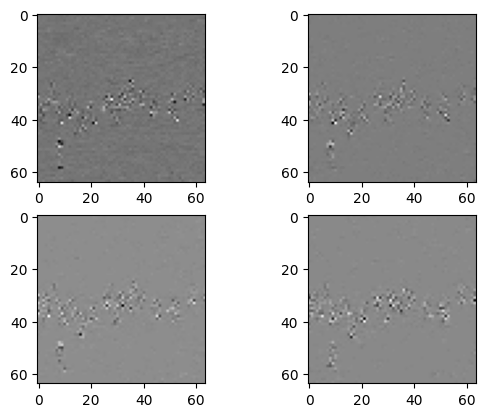

In [31]:
ll= res['level_0']['channel_0']['HHL']
plt.subplots(2,2)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(ll[0,0,i,...].detach().cpu().numpy(), cmap='gray')

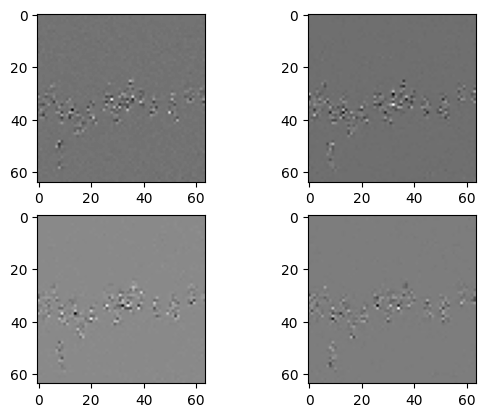

In [37]:
ll= res['level_0']['channel_0']['HHH']
plt.subplots(2,2)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(ll[0,0,i,...].detach().cpu().numpy(), cmap='gray')

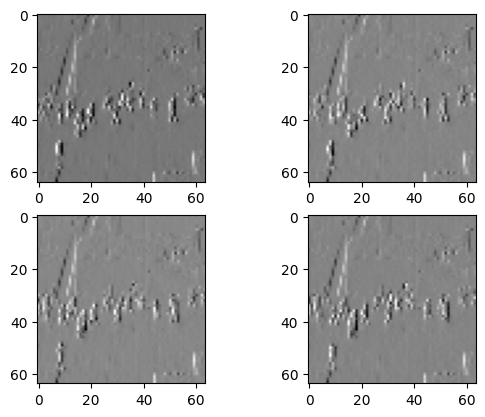

In [ ]:
ll= res['level_0']['channel_0']['HLL']
plt.subplots(2,2)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(ll[0,0,i,...].detach().cpu().numpy(), cmap='gray')

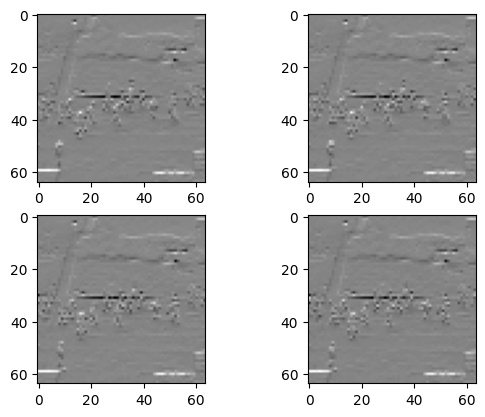

In [33]:
ll= res['level_0']['channel_0']['LHL']
plt.subplots(2,2)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(ll[0,0,i,...].detach().cpu().numpy(), cmap='gray')

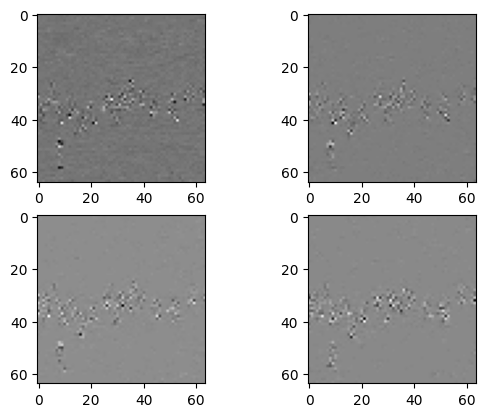

In [36]:
ll= res['level_0']['channel_0']['HHL']
plt.subplots(2,2)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(ll[0,0,i,...].detach().cpu().numpy(), cmap='gray')

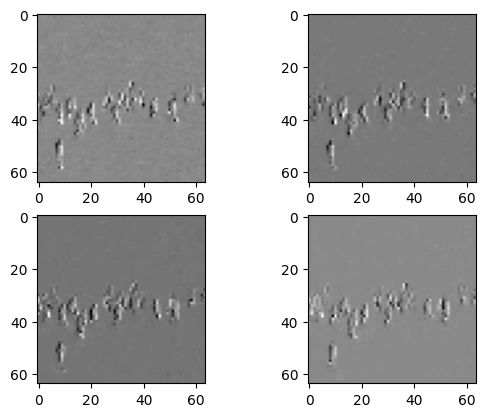

In [35]:
ll= res['level_0']['channel_0']['HLL']
plt.subplots(2,2)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(ll[0,0,i,...].detach().cpu().numpy(), cmap='gray')

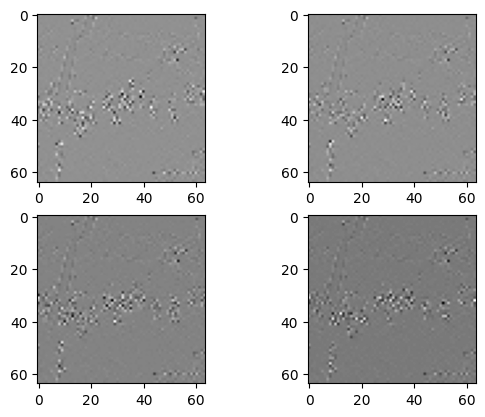

In [34]:
ll= res['level_0']['channel_0']['LHH']
plt.subplots(2,2)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(ll[0,0,i,...].detach().cpu().numpy(), cmap='gray')

In [62]:
class AdvancedWaveletCoeffAttention(nn.Module):
    """
    高级小波系数注意力机制
    结合通道、空间、时间注意力以及序列建模能力
    """
    def __init__(self, num_coefficients, hidden_dim=64):
        """
        初始化高级小波系数注意力机制
        
        参数:
            num_coefficients (int): 小波系数的数量
            hidden_dim (int): 隐藏层维度
        """
        super(AdvancedWaveletCoeffAttention, self).__init__()
        self.num_coefficients = num_coefficients
        self.hidden_dim = hidden_dim
        
        # 通道注意力网络
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(num_coefficients, max(1, num_coefficients // 2), kernel_size=1),
            nn.ReLU(),
            nn.Conv3d(max(1, num_coefficients // 2), num_coefficients, kernel_size=1),
            nn.Sigmoid()
        )
        
        # 空间注意力网络
        self.spatial_attention = nn.Sequential(
            nn.Conv3d(num_coefficients, max(1, num_coefficients // 2), kernel_size=1),
            nn.Conv3d(max(1, num_coefficients // 2), 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # 时间注意力网络
        self.temporal_attention = nn.Sequential(
            nn.AdaptiveAvgPool3d((None, 1, 1)),  # 在时间维度上保持，空间维度池化
            nn.Conv3d(num_coefficients, max(1, num_coefficients // 2), kernel_size=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(max(1, num_coefficients // 2), num_coefficients, kernel_size=(1, 1, 1)),
            nn.Sigmoid()
        )
        
    def forward(self, stacked_coeffs):
        """
        应用高级注意力机制到堆叠的小波系数上
        
        参数:
            stacked_coeffs (torch.Tensor): 堆叠的小波系数张量
                形状: [batch, num_coeffs, channels, time, height, width]
                
        返回:
            torch.Tensor: 加权融合后的特征张量
                形状: [batch, channels, time, height, width]
        """
        batch_size, num_coeffs, channels, time, height, width = stacked_coeffs.shape
        
        # 通道注意力 - 评估不同小波系数在各个通道上的重要性
        channel_weights = self.channel_attention(stacked_coeffs)  # [batch, num_coeffs, 1, 1, 1]
        
        # 空间注意力 - 评估不同小波系数在各个空间位置上的重要性
        spatial_weights = self.spatial_attention(stacked_coeffs)  # [batch, 1, 1, height, width]
        
        # 时间注意力 - 评估不同小波系数在各个时间点上的重要性
        temporal_weights = self.temporal_attention(stacked_coeffs)  # [batch, num_coeffs, 1, time, 1, 1]
        
        # 综合注意力权重
        # 确保所有权重张量的维度匹配
        # channel_weights: [batch, num_coeffs, 1, 1, 1]
        # spatial_weights: [batch, 1, 1, height, width]
        # temporal_weights: [batch, num_coeffs, 1, time, 1, 1]
        
        # 调整spatial_weights维度以匹配其他权重
        spatial_weights = spatial_weights.unsqueeze(3)  # [batch, 1, 1, 1, height, width]
        
        # 调整channel_weights和temporal_weights维度
        channel_weights = channel_weights.unsqueeze(-2).unsqueeze(-1)  # [batch, num_coeffs, 1, 1, 1, 1]
        temporal_weights = temporal_weights.unsqueeze(-1)  # [batch, num_coeffs, 1, time, 1, 1]
        
        # 现在所有权重都有6个维度，可以进行广播
        combined_weights = channel_weights * spatial_weights * temporal_weights  # [batch, num_coeffs, 1, time, height, width]
        
        # 应用注意力权重并融合所有系数
        weighted_coeffs = stacked_coeffs.unsqueeze(2) * combined_weights  # [batch, num_coeffs, 1, time, height, width]
        fused_features = torch.sum(weighted_coeffs, dim=1).squeeze(1)  # [batch, time, height, width]
        
        # 调整输出维度以匹配预期的格式 [batch, channels, time, height, width]
        # 由于我们沿着num_coeffs维度进行了求和，需要调整通道维度
        fused_features = fused_features.unsqueeze(1)  # [batch, 1, time, height, width]
        
        # 如果原始输入有多个通道，我们可能需要复制或调整
        if channels > 1:
            fused_features = fused_features.expand(-1, channels, -1, -1, -1)
            
        return fused_features

In [3]:
import torch
a = torch.rand(1,)
torch.mean(a)

tensor(0.9519)

In [59]:
vs = []
for i in range(8):
    vs.append(train_dataset[i][0])
vs = torch.stack(vs, dim=0)
vs.shape

torch.Size([8, 1, 8, 128, 128])

In [ ]:



x = torch.randn(1, C, T, H, W, requires_grad=True)
y = attention(x)
loss = y.sum()
loss.backward()

for name, p in attention.named_parameters():
    print(name, p.grad is None, p.grad.shape if p.grad is not None else "None")

Using cache found in C:\Users\limax/.cache\torch\hub\pytorch_vision_v0.10.0


RuntimeError: Cannot find callable r3d_34 in hubconf